In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import time

from sklearn.metrics import mean_absolute_error

In [2]:
limit_ListPrice = 1800
price_segment = 30
customer_traffic_segment = 0.0833 #5/(limit_ListPrice/price_segment)
competitiveness_segment = 0.0416 #2.5/(limit_ListPrice/price_segment)
epsilon = 0.4
moving_avg_clusters= {
  "clusteremb0": [],
  "clusteremb1": [],
  "clusteremb2": [],
  "clusteremb3": [],
  "clusteremball": [],
}

# Dynamic Pricing with Reinforcement Learning

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
df_byclusters_train2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_byclusters_embed_train.npy", allow_pickle=True)
df_byclusters_val2 = np.load("/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/df_byclusters_embed_val.npy", allow_pickle=True)

In [5]:
print("\n***************************************************\nTraining\n***************************************************\n")
df_byclusters_train=[]
for df in df_byclusters_train2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_train.append(df)
print("\n***************************************************\nValidation\n***************************************************\n")
df_byclusters_val=[]
for df in df_byclusters_val2:
    df = df[df['ListPriceTRY']<=limit_ListPrice]
    df = df[df['PurchaseAmountTRY']<=limit_ListPrice]
    print('------------------------------------------------------------------------')
    print('Max Purchase Amount:', df['PurchaseAmountTRY'].max() , 'Min Purchase Amount:', df['PurchaseAmountTRY'].min())
    print('Max List Price:', df['ListPriceTRY'].max() , 'Min List Price:', df['ListPriceTRY'].min() )
    print('Max Rate:', df['RatingTripA'].max(), 'Min Rate:', df['RatingTripA'].min())
    print('Max Feature Score:', df['featureScore'].max() , 'Min Feature Score:', df['featureScore'].min())
    print('Max Room Count:', df['empty_rooms'].max() , 'Min Room Count:', df['empty_rooms'].min())
    print('------------------------------------------------------------------------')
    df_byclusters_val.append(df)


***************************************************
Training
***************************************************

------------------------------------------------------------------------
Max Purchase Amount: 1660.5 Min Purchase Amount: 34.0
Max List Price: 1800.0 Min List Price: 37.66666666666666
Max Rate: 5.0 Min Rate: 2.5
Max Feature Score: 1.2850935960086014 Min Feature Score: 0.469892026578073
Max Room Count: 488.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purchase Amount: 1610.0 Min Purchase Amount: 113.2
Max List Price: 1798.0 Min List Price: 154.4
Max Rate: 4.5 Min Rate: 4.0
Max Feature Score: 2.2538542161050463 Min Feature Score: 1.1863269920371249
Max Room Count: 412.001 Min Room Count: 0.001
------------------------------------------------------------------------
------------------------------------------------------------------------
Max Purcha

### UTILITY FUNCTIONS

In [6]:
def round_specific(x, precision, base):
  return round(base * round(float(x)/base),precision)

def round_specific_series(x, precision, base):
  return round(base * round(x/base),precision)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(data_frame):

  print("*Number of Sales: ",data_frame.shape[0])
  print("*Mean Absolute Error: ", mean_absolute_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean Absolute Percentage Error ", mean_absolute_percentage_error(data_frame['ListPriceTRY'],data_frame['list_price']));
 
  print("*Mean of Recommended List Prices:", data_frame['list_price'].mean())
  print("*Mean of Original List Prices:", data_frame['ListPriceTRY'].mean())

  print("*Standard Deviation of Recommended List Prices:", data_frame['list_price'].std())
  print("*Standard Deviation of Original List Prices:", data_frame['ListPriceTRY'].std())
 
  return

#### Reward Functions

In [7]:
def proposed(list_price, purchase, empty_rooms):
    return (list_price-purchase)/empty_rooms
def timestamp(list_price, purchase, empty_rooms,list_price2, purchase2, empty_rooms2):
    return (list_price2-purchase2)/empty_rooms2 - (list_price-purchase)/empty_rooms
def profit(list_price,purchase):
    return (list_price-purchase)/(purchase+0.001)

#### Draw Functions

In [8]:
def draw(moving_avg,moving_avg_val, moving_avg_all, df, validation):
    print("Validation")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_val))], moving_avg_val)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    validation.reset_index()
    validation = validation[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    validation.plot.area(stacked=False);
    plt.show()
    

    print("All Dataset")
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.plot([i for i in range(len(moving_avg_all))],moving_avg_all)
    plt.ylabel(f"Reward 100ma")
    plt.xlabel("episode #")
    plt.show()

    df2 = pd.concat([df,validation])
    df22 = df2[['ListPriceTRY','list_price']]
    plt.figure();
    plt.rcParams['figure.figsize'] = [20, 5]
    df22.plot.area(stacked=False);
    plt.show()
    print("\n\n\|")
    print_metrics(validation)
    print("|")
    print_metrics(df2)
    print("|")
    print_metrics(df)

### AGENT CLASS: SALE
 * Initializes first list price according to purchase amount
 * Takes actions: +10%, 0, -5%

In [9]:
class Sale:
    def __init__(self, purchase, customer_traffic, competitiveness, empty_rooms):
        self.profit = round_specific(np.random.rand()*0.2, 2, 0.01)
        self.purchase = purchase
        if self.purchase > limit_ListPrice:
            self.purchase = limit_ListPrice
        if self.purchase < 0:
            self.purchase = 0
        
        self.list_price = self.purchase + self.purchase*self.profit
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

        self.customer_traffic = customer_traffic
        self.competitiveness = competitiveness
        self.empty_rooms = empty_rooms
    
    def __str__(self):
        return f"{self.profit}"
    
    def __sub__(self,other):
        return self.profit - other.profit
    
    def action(self, choice):
        if choice == 0:
            self.change(-5) # profiti %5 indir
        elif choice == 1:
            self.change(0) 
        elif choice == 2:
            self.change(+10) 
        """
        elif choice == 3:
            self.change(+5) 
        elif choice == 4:
            self.change(+10) # profiti %10 arttir 
        """
    
    def change(self, p=False):
        if not p:
            self.profit = round_specific(np.random.rand(), 2, 0.01)
        else:
            self.profit = self.profit + (p/100)
            
        self.list_price = self.purchase + self.purchase*self.profit 
        self.list_price = round_specific(self.list_price, 0, price_segment)
        if self.list_price > limit_ListPrice:
            self.list_price = limit_ListPrice
        if self.list_price < 0:
            self.list_price = 0

### LOAD Q TABLE

In [10]:
q_table_main = np.load('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/data/qtable/q_table_30_1800_3acts.npy',allow_pickle='TRUE').item()

### RL FUNCTIONS

#### 1- RL WITH PROPOSED REWARD FUNCTION

In [11]:
def RL_proposed(HM_EPISODES, epsilon, df, q_table):
    EPS_DECAY = 0.998
    SHOW_EVERY = 1
    LEARNING_RATE = 0.1
    DISCOUNT = 0.95
    df['list_price']=np.nan

    episode_rewards = []

    for episode in range(HM_EPISODES):
        # initalize agent
        sale = df.iloc[episode]
        
        purchase = sale['PurchaseAmountTRY']
        purchase = round_specific(purchase, 0, price_segment)
        
        customer_traffic = sale['RatingTripA']
        customer_traffic = round_specific(customer_traffic, 1, customer_traffic_segment)
        
        competitiveness = sale['featureScore']
        competitiveness = round_specific(competitiveness, 2, competitiveness_segment)
        
        empty_rooms = sale['empty_rooms']
        
        # get first list price 
        agent = Sale(purchase, customer_traffic, competitiveness, empty_rooms)
        
        list_price = agent.list_price

        episode_reward = 0

        for i in range(200):
            obs = (purchase, list_price, customer_traffic, competitiveness)
            
            if np.random.random() > epsilon:
                # GET THE ACTION
                action = np.argmax(q_table[obs])
            else:
                action = np.random.randint(0, 3)
            
            # Take the action!
            agent.action(action)
            
            ##############################
            # REWARD FUNCTION
            new_obs = (agent.purchase, agent.list_price, agent.customer_traffic, agent.competitiveness)
            max_future_q = np.max(q_table[new_obs])
   
            current_q = q_table[obs][action]
            
            rewardrate = proposed(agent.list_price, agent.purchase,agent.empty_rooms)
            
            if rewardrate < 1:
                reward = -300
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            elif rewardrate < 10 or rewardrate > 100:
                new_q = rewardrate
                reward = 25
            else:
                reward = -1
                new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            
            q_table[obs][action] = new_q

            episode_reward += reward
            if reward ==25:
                break
        df['list_price'].iloc[episode] = agent.list_price
        #print(episode_reward)
        episode_rewards.append(episode_reward)
        epsilon *= EPS_DECAY

    moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')
    return df, moving_avg

#### RUN RL ALGORITHMS

### DRAW AND PRINT METRICS

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


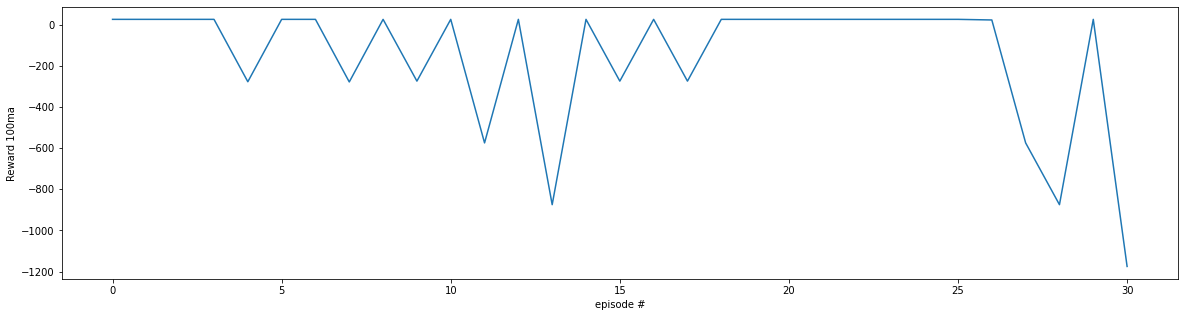

<Figure size 1440x360 with 0 Axes>

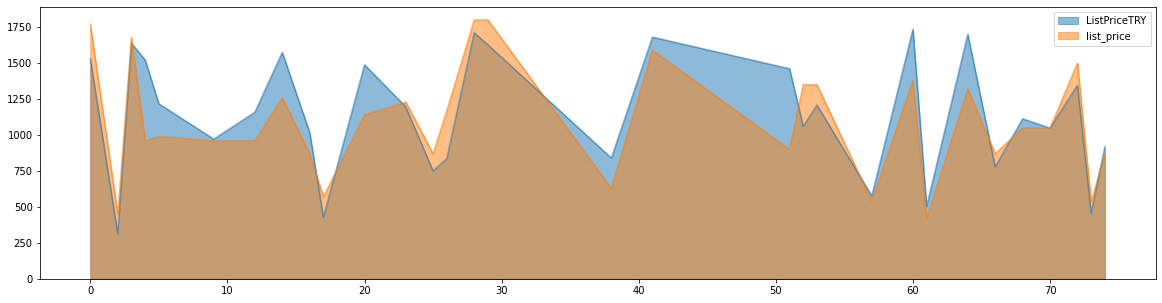

All Dataset


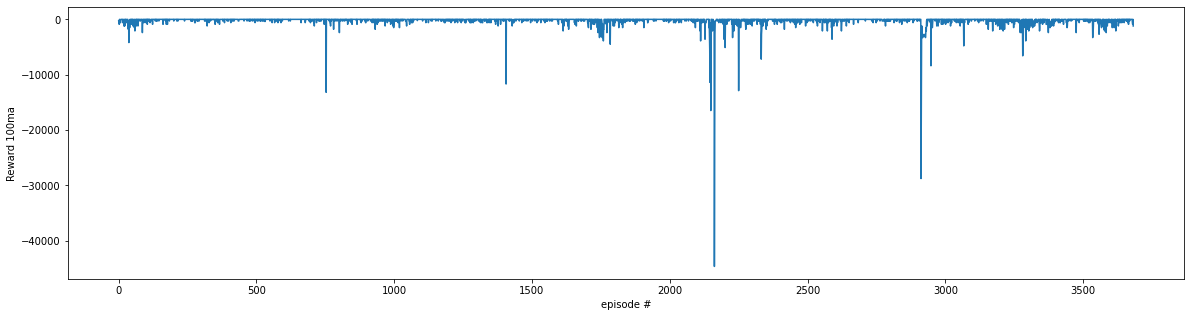

<Figure size 1440x360 with 0 Axes>

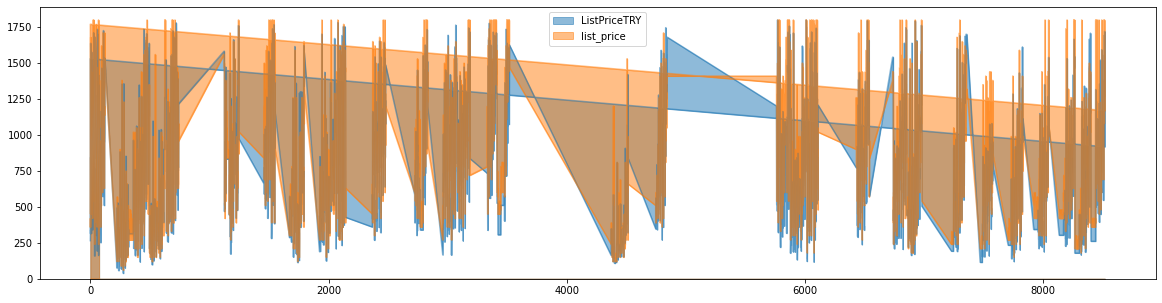



\|
*Number of Sales:  31
*Mean Absolute Error:  184.25594164215005
*Mean Absolute Percentage Error  17.027621885981283
*Mean of Recommended List Prices: 1091.6129032258063
*Mean of Original List Prices: 1142.075030465417
*Standard Deviation of Recommended List Prices: 400.2257427518754
*Standard Deviation of Original List Prices: 427.9103595091296
|
*Number of Sales:  3683
*Mean Absolute Error:  120.30137284701736
*Mean Absolute Percentage Error  21.187977727444185
*Mean of Recommended List Prices: 766.0059733912572
*Mean of Original List Prices: 704.0231478639644
*Standard Deviation of Recommended List Prices: 421.47987770253474
*Standard Deviation of Original List Prices: 422.0323462789599
|
*Number of Sales:  3652
*Mean Absolute Error:  119.75849452482427
*Mean Absolute Percentage Error  21.223292905726044
*Mean of Recommended List Prices: 763.2420591456736
*Mean of Original List Prices: 700.3047446983992
*Standard Deviation of Recommended List Prices: 420.63001814712703
*Standard

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


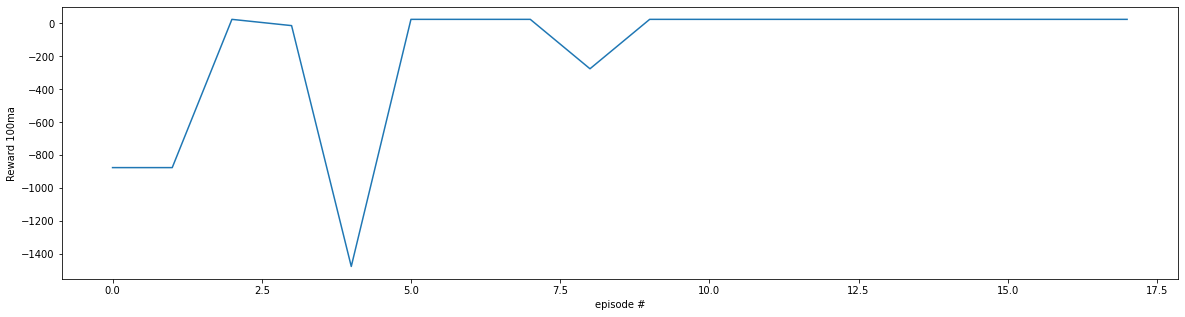

<Figure size 1440x360 with 0 Axes>

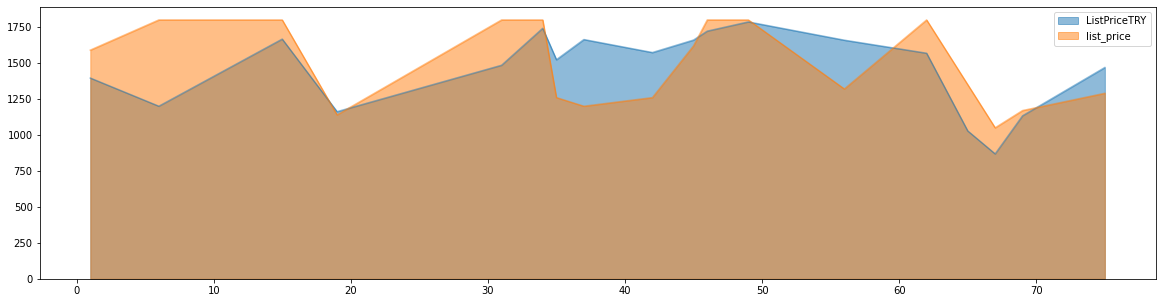

All Dataset


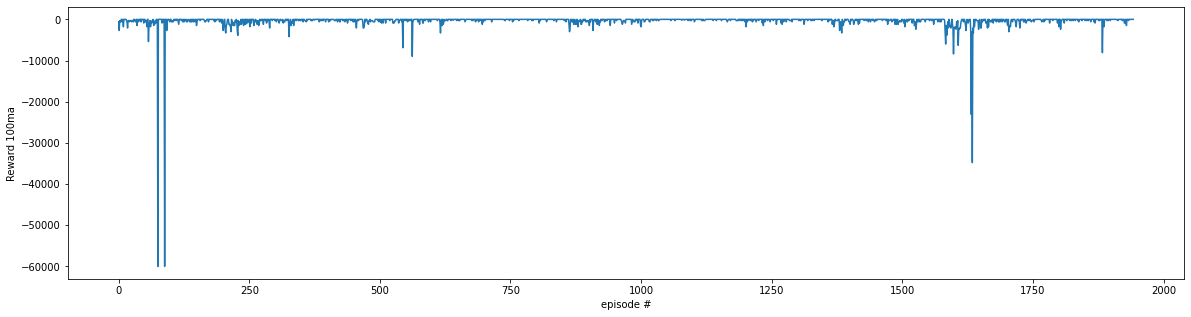

<Figure size 1440x360 with 0 Axes>

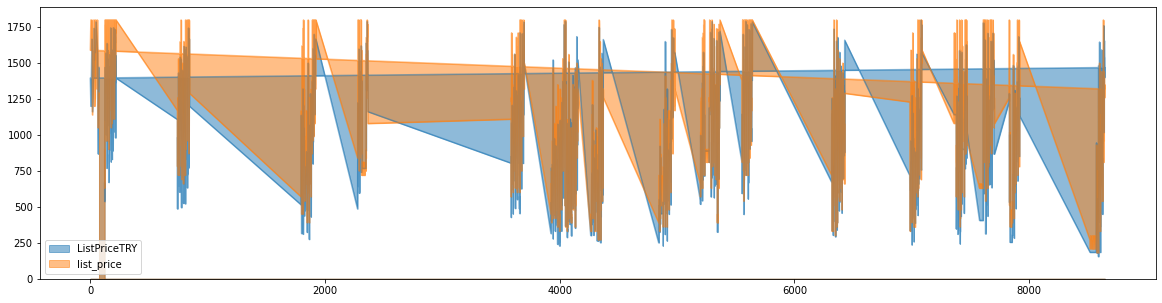



\|
*Number of Sales:  18
*Mean Absolute Error:  210.31482050225193
*Mean Absolute Percentage Error  15.225156059224812
*Mean of Recommended List Prices: 1491.6666666666667
*Mean of Original List Prices: 1461.4868907623754
*Standard Deviation of Recommended List Prices: 286.60795112323524
*Standard Deviation of Original List Prices: 271.2947594772586
|
*Number of Sales:  1943
*Mean Absolute Error:  150.65815763527215
*Mean Absolute Percentage Error  20.0797034826395
*Mean of Recommended List Prices: 1001.9505918682449
*Mean of Original List Prices: 896.6533880310564
*Standard Deviation of Recommended List Prices: 421.71326012786477
*Standard Deviation of Original List Prices: 406.0630230277141
|
*Number of Sales:  1925
*Mean Absolute Error:  150.1003290993731
*Mean Absolute Percentage Error  20.12509665335195
*Mean of Recommended List Prices: 997.3714285714286
*Mean of Original List Prices: 891.371828005517
*Standard Deviation of Recommended List Prices: 420.13740168358765
*Standard D

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


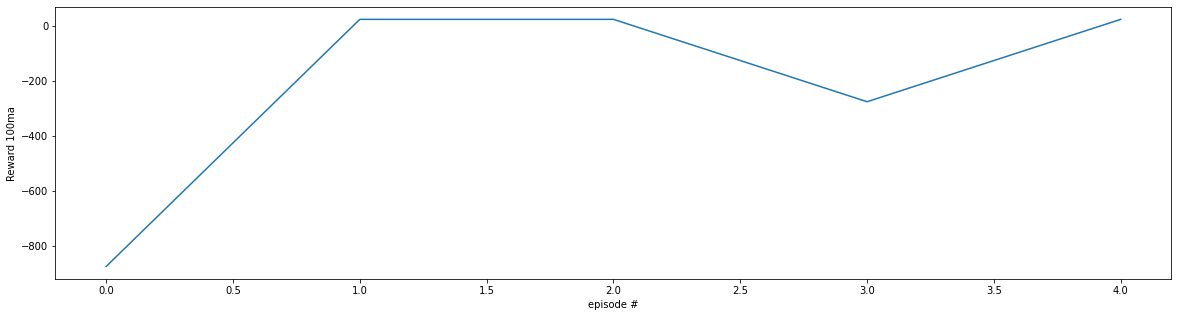

<Figure size 1440x360 with 0 Axes>

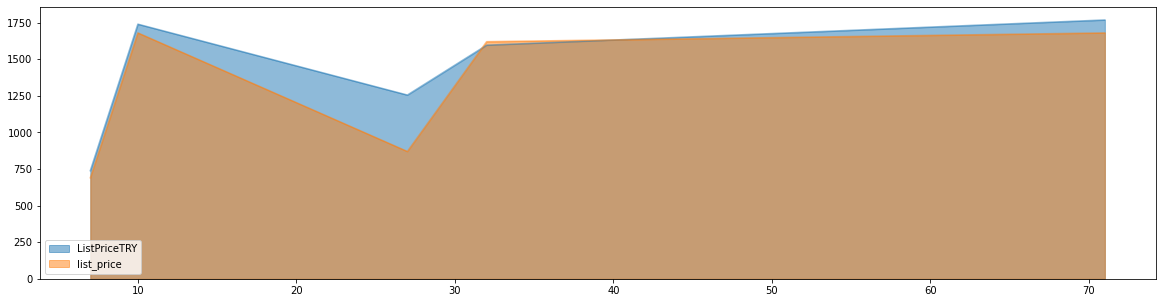

All Dataset


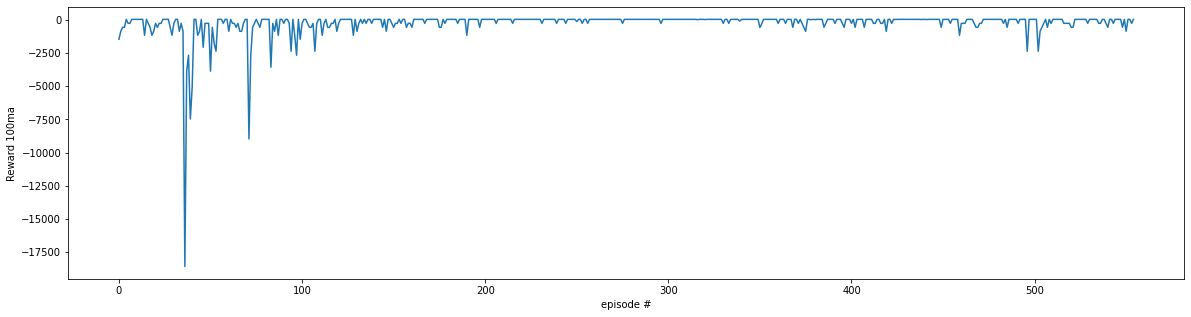

<Figure size 1440x360 with 0 Axes>

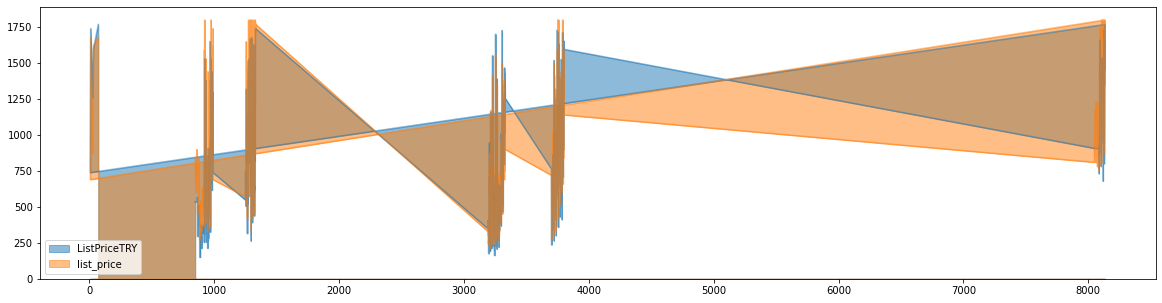



\|
*Number of Sales:  5
*Mean Absolute Error:  121.20839964633072
*Mean Absolute Percentage Error  9.44010873585441
*Mean of Recommended List Prices: 1308.0
*Mean of Original List Prices: 1419.6083996463308
*Standard Deviation of Recommended List Prices: 486.79564500927904
*Standard Deviation of Original List Prices: 431.8880372285561
|
*Number of Sales:  555
*Mean Absolute Error:  129.29244514352354
*Mean Absolute Percentage Error  21.113057972029424
*Mean of Recommended List Prices: 846.918918918919
*Mean of Original List Prices: 772.3998340530047
*Standard Deviation of Recommended List Prices: 426.50293050772973
*Standard Deviation of Original List Prices: 428.3633411383468
|
*Number of Sales:  550
*Mean Absolute Error:  129.3659364662253
*Mean Absolute Percentage Error  21.21917569235829
*Mean of Recommended List Prices: 842.7272727272727
*Mean of Original List Prices: 766.5161198203381
*Standard Deviation of Recommended List Prices: 424.12388876993805
*Standard Deviation of Orig

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Validation


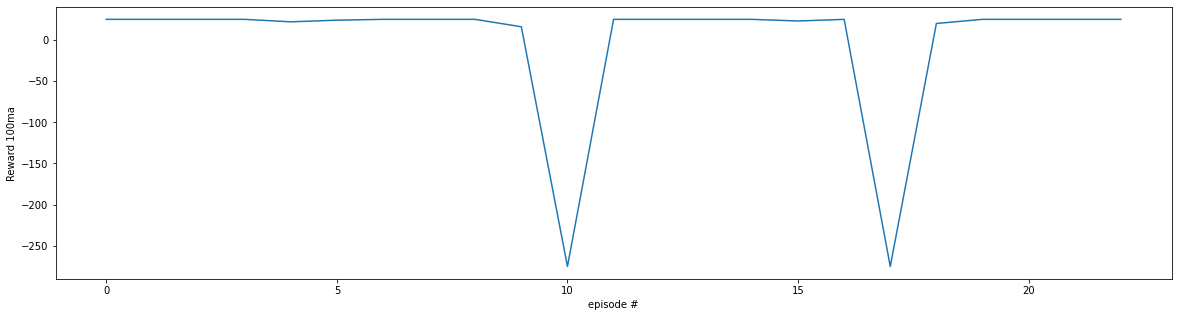

<Figure size 1440x360 with 0 Axes>

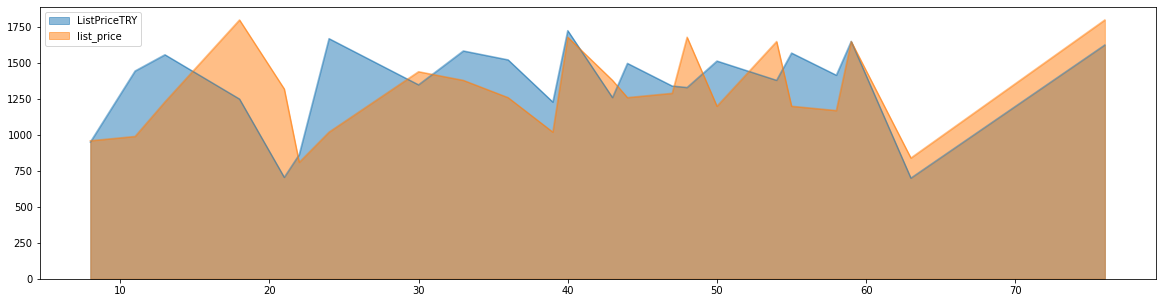

All Dataset


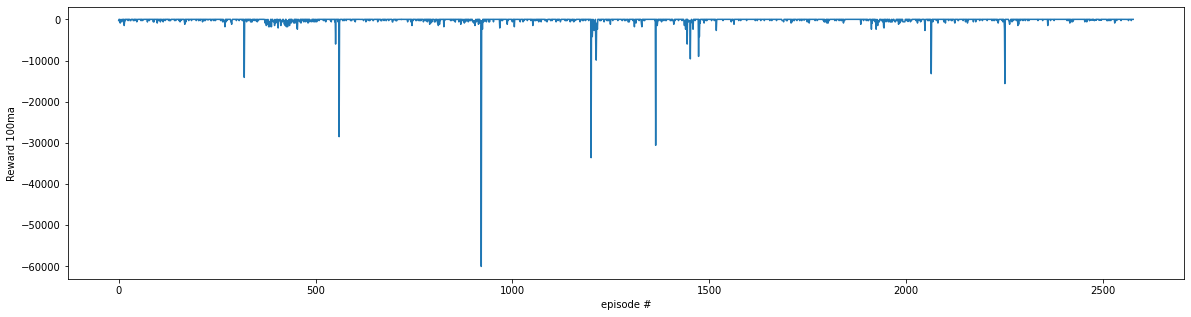

<Figure size 1440x360 with 0 Axes>

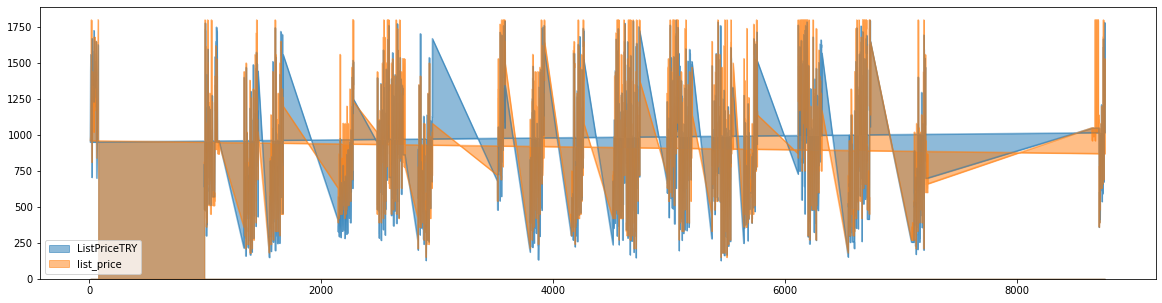



\|
*Number of Sales:  23
*Mean Absolute Error:  249.84703230751458
*Mean Absolute Percentage Error  19.730819831831685
*Mean of Recommended List Prices: 1305.6521739130435
*Mean of Original List Prices: 1353.804222942966
*Standard Deviation of Recommended List Prices: 296.2772977366815
*Standard Deviation of Original List Prices: 295.25709251205535
|
*Number of Sales:  2578
*Mean Absolute Error:  131.9666721552285
*Mean Absolute Percentage Error  18.766274711962332
*Mean of Recommended List Prices: 893.7742435996897
*Mean of Original List Prices: 824.5735384230861
*Standard Deviation of Recommended List Prices: 406.12538164336473
*Standard Deviation of Original List Prices: 399.96522619208014
|
*Number of Sales:  2555
*Mean Absolute Error:  130.9055182282216
*Mean Absolute Percentage Error  18.757591918319672
*Mean of Recommended List Prices: 890.0665362035226
*Mean of Original List Prices: 819.809426585921
*Standard Deviation of Recommended List Prices: 405.1241332086775
*Standard D

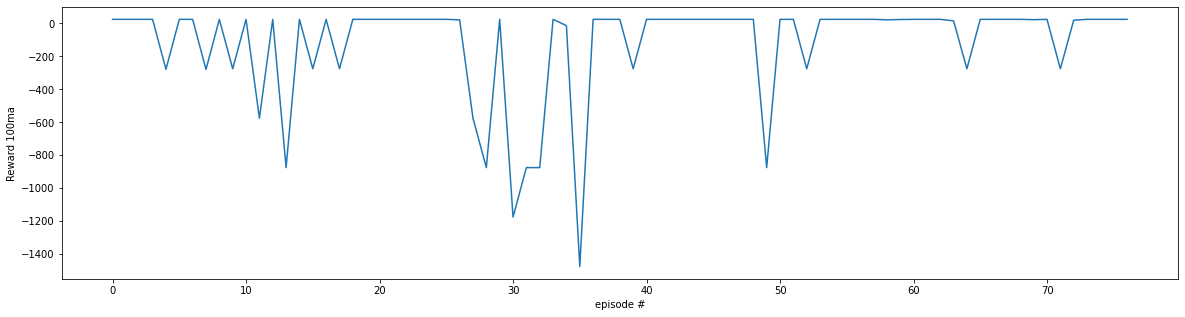

<Figure size 1440x360 with 0 Axes>

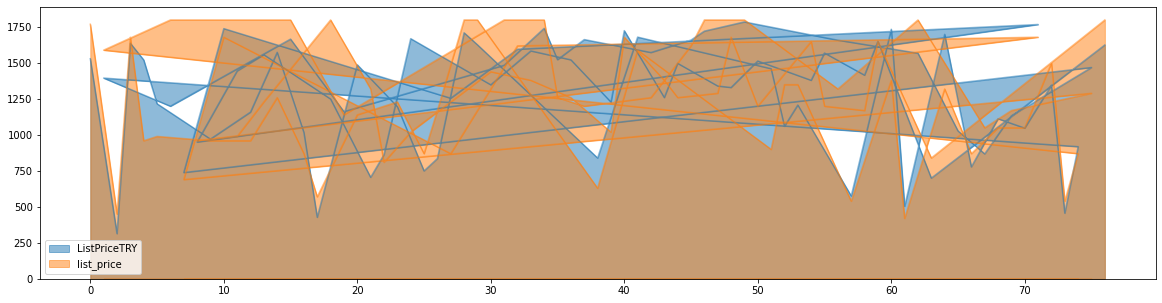

All Dataset


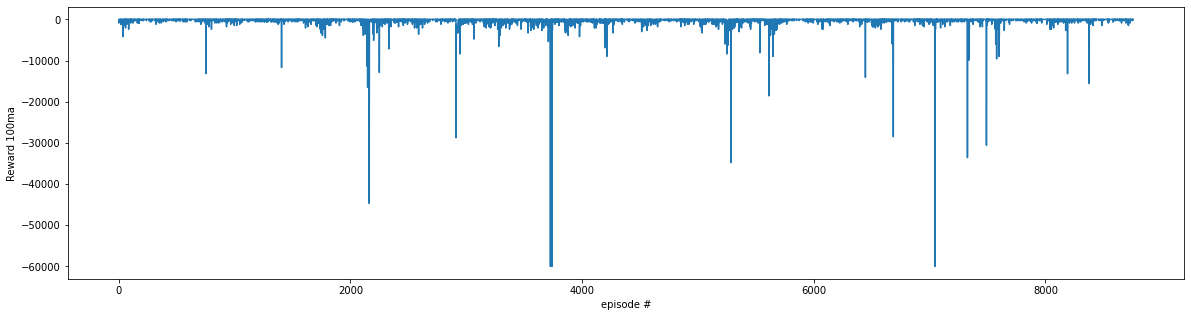

<Figure size 1440x360 with 0 Axes>

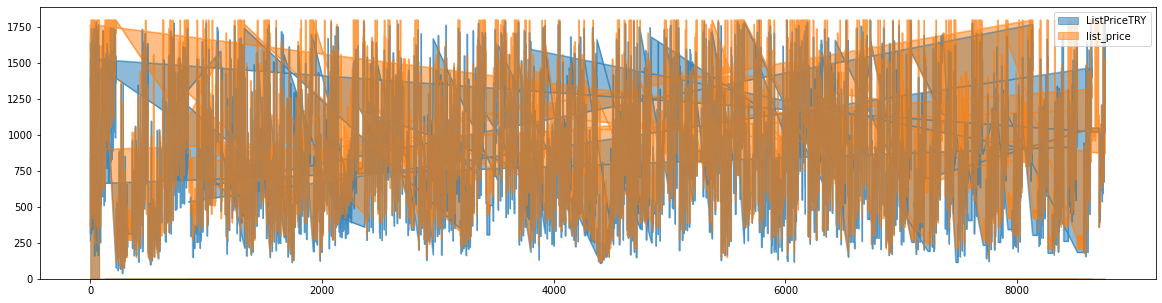



\|
*Number of Sales:  77
*Mean Absolute Error:  205.8457753409308
*Mean Absolute Percentage Error  16.92101931614113
*Mean of Recommended List Prices: 1263.1168831168832
*Mean of Original List Prices: 1298.0081701827346
*Standard Deviation of Recommended List Prices: 380.17745074282766
*Standard Deviation of Original List Prices: 376.7728562697772
|
*Number of Sales:  8759
*Mean Absolute Error:  131.03849119211478
*Mean Absolute Percentage Error  20.22461345117716
*Mean of Recommended List Prices: 861.0777486014385
*Mean of Original List Prices: 786.5677904420043
*Standard Deviation of Recommended List Prices: 427.4219741261343
*Standard Deviation of Original List Prices: 419.65823628005006
|
*Number of Sales:  8682
*Mean Absolute Error:  130.37503105856734
*Mean Absolute Percentage Error  20.25391277718473
*Mean of Recommended List Prices: 857.5120939875604
*Mean of Original List Prices: 782.0318644756328
*Standard Deviation of Recommended List Prices: 426.1434148562588
*Standard De

In [12]:
moving_avg_byclusters_train = []
moving_avg_byclusters_val = []

for i in range(4):
    q_table = q_table_main.copy()
    df_byclusters_train[i].reset_index()
    df_byclusters_train[i], moving_avg_train = RL_proposed(df_byclusters_train[i].shape[0], epsilon, df_byclusters_train[i], q_table)

    moving_avg_byclusters_train.append(moving_avg_train)

    df_byclusters_val[i].reset_index()
    df_byclusters_val[i], moving_avg_val = RL_proposed(df_byclusters_val[i].shape[0], epsilon, df_byclusters_val[i], q_table)

    moving_avg_byclusters_val.append(moving_avg_val)

    moving_avg_clusters[list(moving_avg_clusters.keys())[i]] =[moving_avg_train, moving_avg_val]

    draw(moving_avg_train,
         moving_avg_val, 
         np.concatenate([moving_avg_train, moving_avg_val]), 
         df_byclusters_train[i],  
         df_byclusters_val[i])
draw(np.concatenate(moving_avg_byclusters_train),
     np.concatenate(moving_avg_byclusters_val), 
     np.concatenate([np.concatenate(moving_avg_byclusters_train),np.concatenate(moving_avg_byclusters_val)]), 
     pd.concat(df_byclusters_train),
     pd.concat(df_byclusters_val))

In [13]:
df_byclusters_train[3]

,index,DWHotelID,Unnamed: 0,w,Date,ListPriceTRY,PurchaseAmountTRY,RatingTripA,ProfitRate,featureScore,Date_year,Date_week,rooms_old,#rooms,empty_rooms,rewardrate,Cluster_x,Cluster_Embedding,list_price
991,4869,23.0,6336,18.0,2013-21,641.944444,513.388889,4.5,0.250406,1.139003,2013,21,2.0,85.0,67.001,1.918711,1,2,810.0
992,4870,23.0,6337,15.0,2013-22,797.733333,662.200000,4.5,0.204671,1.139003,2013,22,2.0,85.0,70.001,1.936163,1,2,780.0
993,4871,23.0,6338,32.0,2013-23,676.250000,498.656250,4.5,0.356145,1.139003,2013,23,2.0,85.0,53.001,3.350762,1,2,660.0
994,4872,23.0,6339,49.0,2013-24,480.775510,371.000000,4.5,0.295891,1.139003,2013,24,2.0,85.0,36.001,3.049235,1,2,480.0
995,4873,23.0,6340,24.0,2013-25,689.208333,525.750000,4.5,0.310905,1.139003,2013,25,2.0,85.0,61.001,2.679601,1,2,930.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,959,880.0,1265,12.0,2019-26,1401.500000,1091.416667,4.5,0.284111,1.030392,2019,26,2.0,66.0,54.001,5.742178,1,2,1200.0
8754,960,880.0,1267,29.0,2019-28,1594.034483,1167.655172,4.5,0.365159,1.030392,2019,28,2.0,66.0,37.001,11.523454,1,2,1320.0
8755,961,880.0,1269,14.0,2019-30,1650.714286,1175.500000,4.5,0.404266,1.030392,2019,30,2.0,66.0,52.001,9.138561,1,2,1440.0
8756,962,880.0,1273,14.0,2019-34,1781.428571,1311.357143,4.5,0.358462,1.030392,2019,34,2.0,66.0,52.001,9.039661,1,2,1530.0


In [14]:
moving_avg_cluster = {}
moving_avg_cluster['clusteremb3'] = moving_avg_clusters['clusteremb0']
moving_avg_cluster['clusteremb1'] = moving_avg_clusters['clusteremb1']
moving_avg_cluster['clusteremb0'] = moving_avg_clusters['clusteremb2']
moving_avg_cluster['clusteremb2'] = moving_avg_clusters['clusteremb3']
moving_avg_cluster['clusteremball'] = moving_avg_clusters['clusteremball']

In [15]:
np.save('/content/drive/My Drive/Colab Notebooks/dynamic_pricing/results/moving_avg_clusters_embedding.npy',moving_avg_cluster)